### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

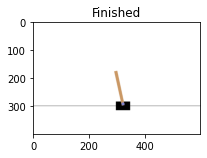

In [2]:
# 导入gym库
import gym

# 创建CartPole环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('CartPole-v1', render_mode='rgb_array')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)

# 循环N次
for i in range(100):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

环境介绍 https://www.gymlibrary.dev/environments/classic_control/cart_pole/

### DQN

In [3]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 定义简单神经网络
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim # 网络的输入维度
        self.output_dim = output_dim # 网络的输出维度
        
        # 定义一个仅包含全连接层的网络，激活函数使用ReLU函数
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )
    
    # 定义前向传播，输出动作Q值
    def forward(self, state):
        action = self.fc(state)
        return action

In [4]:
# 经验回放缓冲区
class ReplayBuffer:
    # 构造函数，max_size是缓冲区的最大容量
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = collections.deque(maxlen = self.max_size)  # 用collections的队列存储，先进先出

    # 添加experience（五元组）到缓冲区
    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    # 从buffer中随机采样，数量为batch_size
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done
    
    # 返回缓冲区数据数量
    def __len__(self):
        return len(self.buffer)

In [5]:
# 定义DQN类
class DQN:
    # 构造函数，参数包含环境，学习率，折扣因子，经验回放缓冲区大小，目标网络更新频率
    def __init__(self, env, learning_rate=0.001, gamma=0.99, buffer_size=10000, T=10):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.replay_buffer = ReplayBuffer(max_size=buffer_size)
        self.T = T

        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 定义Q网络和目标网络，模型结构是一样的
        self.model = Net(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_model = Net(env.observation_space.shape[0], env.action_space.n).to(self.device)

        # 初始化时，令目标网络的参数就等于Q网络的参数
        for param, target_param in zip(self.model.parameters(), self.target_model.parameters()):
            target_param.data.copy_(param)

        # 定义Adam优化器
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # 记录模型更新的次数，用于决定何时更新目标模型
        self.update_count = 0
    
    # 根据epsilon-greedy策略选择动作
    def choose_action(self, state, epsilon=0.1):
        if np.random.rand() < epsilon: # 以epsilon的概率随机选择一个动作
            return np.random.randint(self.env.action_space.n)
        else: # 否则选择模型认为最优的动作
            state = torch.FloatTensor(np.array([state])).to(self.device)
            action = self.model(state).argmax().item()
            return action
    
    # 计算损失函数，参数batch为随机采样的一批数据
    def compute_loss(self, batch):
        # 取出数据，并将其转换为numpy数组
        # 然后进一步转换为tensor，并将数据转移到指定计算资源设备上
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.tensor(np.array(actions)).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).view(-1, 1).to(self.device)

        # 计算当前Q值，即Q网络对当前状态动作样本对的Q值估计
        curr_Q = self.model(states).gather(1, actions)
        # 计算目标网络对下一状态的Q值估计
        next_Q = self.target_model(next_states)
        # 选择下一状态中最大的Q值
        max_next_Q = torch.max(next_Q, 1)[0].view(-1, 1)
        # 计算期望的Q值，若达到终止状态则直接是reward
        expected_Q = rewards + (1 - dones) * self.gamma * max_next_Q
        
        # 计算当前Q值和期望Q值之间的均方误差，返回结果
        loss = torch.mean(F.mse_loss(curr_Q, expected_Q))
        return loss
    
    # 模型更新，参数为批次大小
    def update(self, batch_size):
        # 从经验回放缓冲区中随机采样
        batch = self.replay_buffer.sample(batch_size)
        # 计算这部分数据的损失
        loss = self.compute_loss(batch)

        # 梯度清零、反向传播、更新参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 每隔一段时间，更新目标网络的参数
        if self.update_count % self.T == 0:
            for param, target_param in zip(self.model.parameters(), self.target_model.parameters()):
                target_param.data.copy_(param)
        # 记录模型更新的次数
        self.update_count += 1

In [6]:
# 定义超参数
max_episodes = 200 # 训练episode数
max_steps = 500 # 每个回合的最大步数
batch_size = 32 # 采样数

# 创建DQN对象
agent = DQN(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0

    # 循环进行每一步操作
    for step in range(max_steps):
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated
        
        # 将这个五元组加到缓冲区中
        agent.replay_buffer.add(state, action, reward, next_state, done)
        # 累计奖励
        episode_reward += reward

        # 如果经验回放缓冲区已经有足够数据，就更新网络参数
        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)
        
        # 更新当前状态
        state = next_state

        if done:
            break
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)
    # 打印中间值
    if episode % 40 == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: 11.0                        
Episode 40: 97.0                                
Episode 80: 268.0                               
Episode 120: 484.0                               
Episode 160: 432.0                               
100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


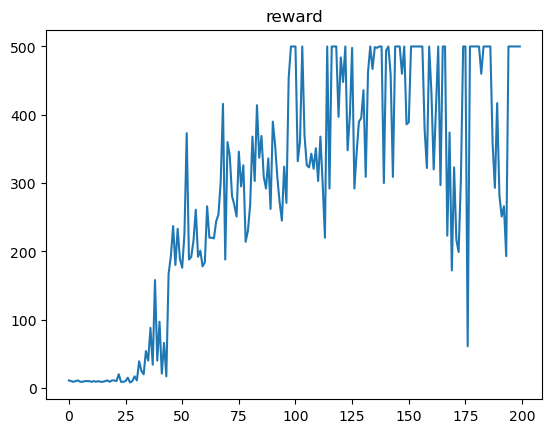

In [7]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards)
plt.title("reward")
plt.show()

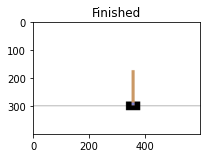

In [12]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 开始游戏
for i in range(500):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过Q网络找到当前状态下的最优动作
    action = agent.choose_action(observation, 0)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()